In [15]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  False


In [16]:
import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json
import uuid


In [17]:
parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')


In [18]:
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)


val_df['propaganda'] = val_df.apply(transform_binaryify, axis=1)
val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

train_df
val_df

,label,tagged_in_context,propaganda,original_without_snip_tags
0,not_propaganda,"On average, between 300 and 600 infections are...",0,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1,Mostly because the country would not last lon...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1,Lyndon Johnson gets Earl Warren and Sen. Rich...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0,You may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...,1,It must be exacted from him directly in order ...
...,...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0,"NewsCatholic Church, Family, Marriage"
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0,"Remember our saying, modern day fairy tales s..."
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0,Why not open up to Iran with massive amounts...
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1,He also sang an Islamic State fight song and ...


In [19]:
class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, max_len):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.labels=torch.tensor([label for label in df['propaganda']])
        self.texts=[tokenizer(text,padding='max_length',max_length=max_len,truncation=True,return_tensors="pt") for text in df['original_without_snip_tags']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [16]:
import torch
from torch import nn
from torchsummary import summary
# from transformers import BertModel

In [20]:
class BertClassifier(nn.Module):
    def __init__(self,dropout=0.5,num_classes=2): # num_classes = 8 for multiclass
        super().__init__()
        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):
        _, x = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        x=self.dropout(x)
        x=self.linear(x)
        x=self.relu(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = BertClassifier()

for layer_name, params in model.named_parameters():
    print(layer_name, params.shape)


cpu


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder

In [22]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)


In [25]:
# normal model

epochs = 16
lr = 5e-6
bn=50
max_len=150
n_classes = 2
dr = 0.5


train_data = CustomPropagandaDataset_vanilla(train_df, max_len)
val_data = CustomPropagandaDataset_vanilla(val_df, max_len)

train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)

model=BertClassifier(num_classes=n_classes, dropout=dr).to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

best_val_acc = 0
best_epoch = 0
best_model_state = None

model_id = 'bert4seq_'+str(uuid.uuid4())


for epoch_num in range(epochs):


        total_acc_train=0
        total_loss_train=0
        model.train()

        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)
            

            output_1=model(input_id,mask)

            batch_loss_1=criterion(output_1,train_label.long())

            total_loss_train += batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0

        y_true = []
        y_pred = []
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output_2= model(input_id,mask)

                # for scoring
                predicted = output_2.argmax(dim=1)
                y_true.extend(val_label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                batch_loss_2=criterion(output_2,val_label.long())

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        if val_acc > best_val_acc:
          best_epoch = epoch_num
          y_true_best = y_true.copy()
          y_pred_best = y_pred.copy()
          best_val_acc = val_acc
          best_model_state = model.state_dict()

        if epoch_num == epochs-1:
            print(f'______{model_id}______')
            print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
            print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
            print('____________')

# Plot the accuracy and loss curves over epochs
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curves')

#   plt.subplot(1, 2, 2)
#   plt.plot(epochs_range, train_loss_list, label='Training Loss')
#   plt.plot(epochs_range, val_loss_list, label='Validation Loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend(loc='upper right')
#   plt.title('Loss Curves')
plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')

plt.tight_layout()
plt.show()
# analysis of best performing model

cm = confusion_matrix(y_true_best, y_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
classes = ['Class 0', 'Class 1']  # Replace with your class labels

# Compute precision, recall, F1-score, and other metrics for best one
report = classification_report(y_true, y_pred, target_names=classes)
print('Classification Report:')
print(report)
results_dict = {
  'model_id': model_id,
  'train_accuracy': train_acc_list,
  'train_loss': train_loss_list,
  'val_accuracy': val_acc_list,
  'val_loss': val_loss_list,
  'hyperparameters': {
      'learning_rate': lr,
      'num_epochs': epochs,
      'batch_size': bn,
      'max_len': max_len,
      'dropout': dr
  },
  'results': {
      "classes": n_classes,
      "last_acc": val_acc_list[-1],
      'best_acc': best_val_acc,
      'best_acc_epoch': best_epoch,
      'confusion_matrix': cm.tolist(),
      'classification_report': report
  }
}

# Save the results dictionary as a JSON file with the model ID
results_filename = f'./results/binary_results_{model_id}.json'
with open(results_filename, 'w') as f:
    json.dump(results_dict, f, indent=4)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/52 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not SequenceClassifierOutput

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 52/52 [03:05<00:00,  3.58s/it]


Epochs: 1 | Train Loss: 0.014 | Train Accuracy: 0.593
Val loss: 0.012 | Val Accuracy: 0.667


100%|██████████| 52/52 [02:32<00:00,  2.93s/it]


Epochs: 2 | Train Loss: 0.011 | Train Accuracy: 0.738
Val loss: 0.011 | Val Accuracy: 0.745


100%|██████████| 52/52 [04:36<00:00,  5.32s/it]


Epochs: 3 | Train Loss: 0.010 | Train Accuracy: 0.785
Val loss: 0.011 | Val Accuracy: 0.753


100%|██████████| 52/52 [02:45<00:00,  3.19s/it]


Epochs: 4 | Train Loss: 0.009 | Train Accuracy: 0.818
Val loss: 0.010 | Val Accuracy: 0.766


100%|██████████| 52/52 [02:24<00:00,  2.78s/it]


Epochs: 5 | Train Loss: 0.008 | Train Accuracy: 0.856
Val loss: 0.011 | Val Accuracy: 0.770


100%|██████████| 52/52 [16:31<00:00, 19.08s/it]   


Epochs: 6 | Train Loss: 0.007 | Train Accuracy: 0.884
Val loss: 0.011 | Val Accuracy: 0.767


100%|██████████| 52/52 [01:37<00:00,  1.87s/it]


Epochs: 7 | Train Loss: 0.006 | Train Accuracy: 0.902
Val loss: 0.011 | Val Accuracy: 0.770


100%|██████████| 52/52 [01:35<00:00,  1.84s/it]


Epochs: 8 | Train Loss: 0.005 | Train Accuracy: 0.927
Val loss: 0.011 | Val Accuracy: 0.766


100%|██████████| 52/52 [01:44<00:00,  2.01s/it]


Epochs: 9 | Train Loss: 0.004 | Train Accuracy: 0.936
Val loss: 0.012 | Val Accuracy: 0.775


100%|██████████| 52/52 [01:37<00:00,  1.88s/it]


Epochs: 10 | Train Loss: 0.004 | Train Accuracy: 0.950
Val loss: 0.012 | Val Accuracy: 0.787


100%|██████████| 52/52 [01:46<00:00,  2.05s/it]


Epochs: 11 | Train Loss: 0.003 | Train Accuracy: 0.962
Val loss: 0.012 | Val Accuracy: 0.789


100%|██████████| 52/52 [01:55<00:00,  2.21s/it]


Epochs: 12 | Train Loss: 0.002 | Train Accuracy: 0.972
Val loss: 0.013 | Val Accuracy: 0.759


100%|██████████| 52/52 [01:45<00:00,  2.03s/it]


Epochs: 13 | Train Loss: 0.002 | Train Accuracy: 0.973
Val loss: 0.014 | Val Accuracy: 0.781


100%|██████████| 52/52 [01:37<00:00,  1.88s/it]


Epochs: 14 | Train Loss: 0.002 | Train Accuracy: 0.982
Val loss: 0.014 | Val Accuracy: 0.780


100%|██████████| 52/52 [01:34<00:00,  1.83s/it]


Epochs: 15 | Train Loss: 0.002 | Train Accuracy: 0.977
Val loss: 0.014 | Val Accuracy: 0.781


100%|██████████| 52/52 [02:01<00:00,  2.33s/it]


Epochs: 16 | Train Loss: 0.001 | Train Accuracy: 0.986
Val loss: 0.015 | Val Accuracy: 0.791


100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


Epochs: 17 | Train Loss: 0.001 | Train Accuracy: 0.986
Val loss: 0.016 | Val Accuracy: 0.777


100%|██████████| 52/52 [02:44<00:00,  3.15s/it]


Epochs: 18 | Train Loss: 0.001 | Train Accuracy: 0.989
Val loss: 0.016 | Val Accuracy: 0.778


100%|██████████| 52/52 [04:56<00:00,  5.71s/it]


Epochs: 19 | Train Loss: 0.001 | Train Accuracy: 0.991
Val loss: 0.016 | Val Accuracy: 0.780


100%|██████████| 52/52 [09:57<00:00, 11.48s/it]


Epochs: 20 | Train Loss: 0.001 | Train Accuracy: 0.988
Val loss: 0.016 | Val Accuracy: 0.783
______42008382-f62d-4129-a8fe-5ac18f4ba56d______
LR: 5e-06 FINAL ACC = 0.783
LR: 5e-06 BEST ACC = 0.791
____________


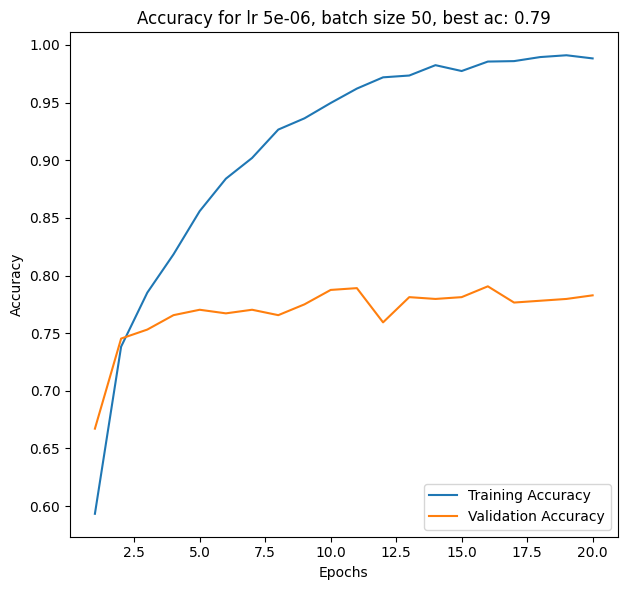

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.77      0.79       331
     Class 1       0.76      0.80      0.78       309

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.78      0.78      0.78       640



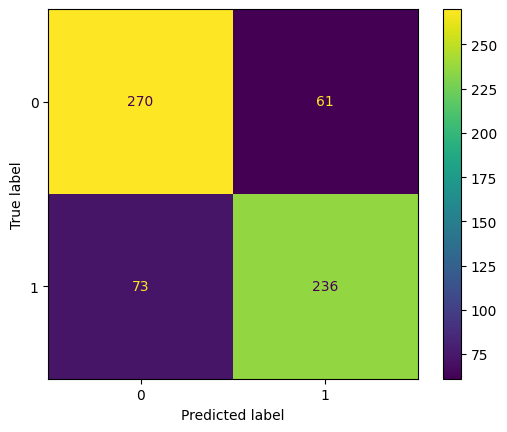

In [37]:
# BERT4Sequence
epochs = 20
lr = 1e-6
bn=50
max_len=150
n_classes = 2
dr = 0.5


for lr in [5e-6]:
    train_data = CustomPropagandaDataset_vanilla(train_df, max_len)
    val_data = CustomPropagandaDataset_vanilla(val_df, max_len)

    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_classes).to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0
    best_epoch = 0
    best_model_state = None

    model_id = str(uuid.uuid4())


    for epoch_num in range(epochs):


            total_acc_train=0
            total_loss_train=0
            model.train()

            for train_input,train_label in tqdm(train_dataloader):

                input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

                output_1=model(input_id,mask, labels=train_label)

                batch_loss_1=output_1.loss

                total_loss_train += batch_loss_1.item()

                acc=(output_1.logits.argmax(dim=1)==train_label).sum().item()
                total_acc_train+=acc

                model.zero_grad()
                batch_loss_1.backward()
                optimizer.step()

            total_acc_val=0
            total_loss_val=0

            y_true = []
            y_pred = []
            model.eval()
            with torch.no_grad():
                for val_input,val_label in val_dataloader:

                    input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                    output_2= model(input_id,mask, labels=val_label)

                    # for scoring
                    predicted = output_2.logits.argmax(dim=1)
                    y_true.extend(val_label.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

                    # batch_loss_2=criterion(output_2,val_label.long())
                    batch_loss_2=output_2.loss

                    total_loss_val+=batch_loss_2.item()

                    acc=(output_2.logits.argmax(dim=1)==val_label).sum().item()
                    total_acc_val+=acc
            
            train_acc = total_acc_train / len(train_data)
            train_loss = total_loss_train / len(train_data)
            val_acc = total_acc_val / len(val_data)
            val_loss = total_loss_val / len(val_data)

            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

            print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
            print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
            if val_acc > best_val_acc:
                best_epoch = epoch_num
                y_true_best = y_true.copy()
                y_pred_best = y_pred.copy()
                best_val_acc = val_acc
                best_model_state = model.state_dict()

            if epoch_num == epochs-1:
                print(f'______{model_id}______')
                print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
                print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
                print('____________')

    # Plot the accuracy and loss curves over epochs
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Curves')

    #   plt.subplot(1, 2, 2)
    #   plt.plot(epochs_range, train_loss_list, label='Training Loss')
    #   plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    #   plt.xlabel('Epochs')
    #   plt.ylabel('Loss')
    #   plt.legend(loc='upper right')
    #   plt.title('Loss Curves')
    plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')

    plt.tight_layout()
    plt.show()
    # analysis of best performing model

    cm = confusion_matrix(y_true_best, y_pred_best)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    classes = ['Class 0', 'Class 1']  # Replace with your class labels

    # Compute precision, recall, F1-score, and other metrics for best one
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)
    results_dict = {
    'model_id': model_id,
    'train_accuracy': train_acc_list,
    'train_loss': train_loss_list,
    'val_accuracy': val_acc_list,
    'val_loss': val_loss_list,
    'hyperparameters': {
        'learning_rate': lr,
        'num_epochs': epochs,
        'batch_size': bn,
        'max_len': max_len,
        'dropout': dr
    },
    'results': {
        "classes": n_classes,
        "last_acc": val_acc_list[-1],
        'best_acc': best_val_acc,
        'best_acc_epoch': best_epoch,
        'confusion_matrix': cm.tolist(),
        'classification_report': report
    }
    }

    # Save the results dictionary as a JSON file with the model ID
    results_filename = f'./results/bert4seq_binary_results_{model_id}.json'
    with open(results_filename, 'w') as f:
        json.dump(results_dict, f, indent=4)



